In [44]:
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red

def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

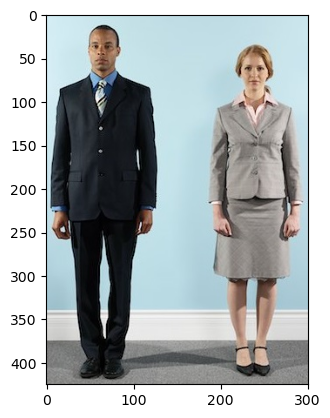

In [45]:
IMAGE_FILE = './images/000000002299.jpg'
IMAGE_FILENAMES =[]
IMAGE_FILENAMES.append(IMAGE_FILE)
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(IMAGE_FILE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

./images/000000002299.jpg


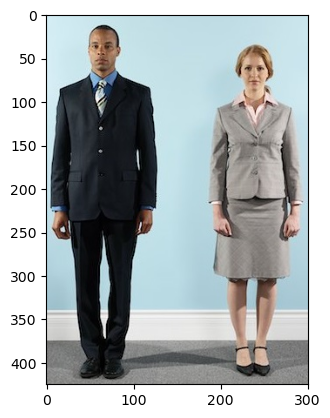

In [46]:
import cv2
import matplotlib.pyplot as plt
import math

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    
# Preview the image(s)
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Download test image

Let's grab a test image that we'll use later. This image comes from [Pixabay](https://pixabay.com/photos/pet-cute-animal-domestic-mammal-3157961/).

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

## Running inference and visualizing the results

Here are the steps to run object detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/object_detector/python) to learn more about configuration options that this solution supports.

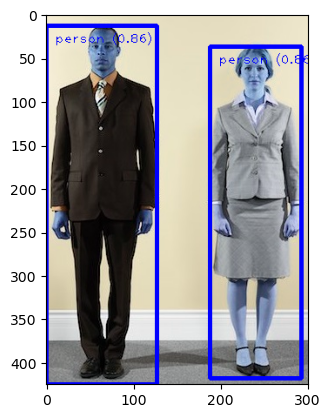

In [47]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='models/efficientdet_lite0.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_annotated_image)

In [48]:
print(detection_result)

DetectionResult(detections=[Detection(bounding_box=BoundingBox(origin_x=188, origin_y=37, width=105, height=381), categories=[Category(index=None, score=0.85546875, display_name=None, category_name='person')], keypoints=[]), Detection(bounding_box=BoundingBox(origin_x=0, origin_y=13, width=127, height=412), categories=[Category(index=None, score=0.85546875, display_name=None, category_name='person')], keypoints=[])])


In [49]:
# combine all of the images, their xy coordinates
# if there's an object already in the dictionary with that key, add a duplicate with the order number
detected_objects = {}
for detection in detection_result.detections:
    category = detection.categories[0]
    category_name = category.category_name
    # detected_objects[category_name] = detection.bounding_box
    if category_name in detected_objects:
        detected_objects[category_name + str(len(detected_objects))] = detection.bounding_box
    else:
        detected_objects[category_name] = detection.bounding_box        

In [50]:
detected_objects

{'person': BoundingBox(origin_x=188, origin_y=37, width=105, height=381),
 'person1': BoundingBox(origin_x=0, origin_y=13, width=127, height=412)}

In [51]:
#FIXME: uncomment code
# let the user select from the options which object they want to crop
print("Which object would you like to segment?")
# show all the options with numbers next to them, and let them pick.
for i, key in enumerate(detected_objects.keys()):
    print(f"{i}: {key}")
object_in_question = int(input("Enter the number of the object you'd like to segment: "))
if object_in_question > len(detected_objects.keys()):
    print("Invalid input.")
    exit()

Which object would you like to segment?
0: person
1: person1


In [52]:

# print that object's details from the dictionary
selected = list(detected_objects.keys())[object_in_question]
print(f"Selected object: {selected}")
selected_object = detected_objects[selected]
print(selected_object)

Selected object: person
BoundingBox(origin_x=188, origin_y=37, width=105, height=381)


In [53]:
# now let's do image segmentation based on interactive selection
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int):
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [54]:
def normalize_bbox(bbox, image_width, image_height):
    # find the central point and normalize it 
    center_x = bbox.origin_x + (bbox.width / 2)
    
    # get the upper 20% of the image, so just change y 
    
    #FIXME: THe key assumption is that a person's head is in the upper 20% of the image. 
    center_y = bbox.origin_y + 0.2 * bbox.height
    
    # normalize the center point
    normalized_x = center_x / image_width
    normalized_y = center_y / image_height
    print(f"bbox width:{bbox.width}, bbox height:{bbox.height}")
    print(f"image width:{image_width}, image height:{image_height}")
    print(f"bbox origin_x:{bbox.origin_x}, bbox origin_y:{bbox.origin_y}")
    print(f"central point x:{center_x}, central point y:{center_y}")
    return normalized_x, normalized_y


In [55]:
# # x and y are normalized to [0.0, 1.0] by the image width and height respectively
x = normalize_bbox(selected_object, img.shape[1], img.shape[0])[0]
y = normalize_bbox(selected_object, img.shape[1], img.shape[0])[1]
print(x)
print(y)
print(img.shape)

bbox width:105, bbox height:381
image width:301, image height:425
bbox origin_x:188, bbox origin_y:37
central point x:240.5, central point y:113.2
bbox width:105, bbox height:381
image width:301, image height:425
bbox origin_x:188, bbox origin_y:37
central point x:240.5, central point y:113.2
0.7990033222591362
0.26635294117647057
(425, 301, 3)


In [56]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.components import containers


BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white

RegionOfInterest = vision.InteractiveSegmenterRegionOfInterest
NormalizedKeypoint = containers.keypoint.NormalizedKeypoint

# Create the options that will be used for InteractiveSegmenter
base_options = python.BaseOptions(model_asset_path='./models/magic_touch.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the interactive segmenter
with vision.InteractiveSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the masks for the segmented image
    roi = RegionOfInterest(format=RegionOfInterest.Format.KEYPOINT,
                           keypoint=NormalizedKeypoint(x, y))
    segmentation_result = segmenter.segment(image, roi)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
    output_image = np.where(condition, fg_image, bg_image)

    # Draw a white dot with black border to denote the point of interest
    thickness, radius = 6, -1
    keypoint_px = _normalized_to_pixel_coordinates(x, y, image.width, image.height)
    cv2.circle(output_image, keypoint_px, thickness + 5, (0, 0, 0), radius)
    cv2.circle(output_image, keypoint_px, thickness, (255, 255, 255), radius)

In [57]:
OVERLAY_COLOR = (100, 100, 0) # cyan

# Create the segmenter
with python.vision.InteractiveSegmenter.create_from_options(options) as segmenter:

  # Loop through available image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe Image
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the category masks for the image
    roi = RegionOfInterest(format=RegionOfInterest.Format.KEYPOINT,
                           keypoint=NormalizedKeypoint(x, y))
    segmentation_result = segmenter.segment(image, roi)
    category_mask = segmentation_result.category_mask

    # Convert the BGR image to RGB
    image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

    # Create an overlay image with the desired color (e.g., (255, 0, 0) for red)
    overlay_image = np.zeros(image_data.shape, dtype=np.uint8)
    overlay_image[:] = OVERLAY_COLOR

    # Create the condition from the category_masks array
    alpha = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1

    # Create an alpha channel from the condition with the desired opacity (e.g., 0.7 for 70%)
    alpha = alpha.astype(float) * 0.7

    # Blend the original image and the overlay image based on the alpha channel
    output_image = image_data * (1 - alpha) + overlay_image * alpha
    output_image = output_image.astype(np.uint8)

    # Draw a white dot with black border to denote the point of interest
    thickness, radius = 6, -1
    keypoint_px = _normalized_to_pixel_coordinates(x, y, image.width, image.height)
    cv2.circle(output_image, keypoint_px, thickness + 5, (0, 0, 0), radius)
    cv2.circle(output_image, keypoint_px, thickness, (255, 255, 255), radius)

    print(f'{image_file_name}:')
  

./images/000000002299.jpg:


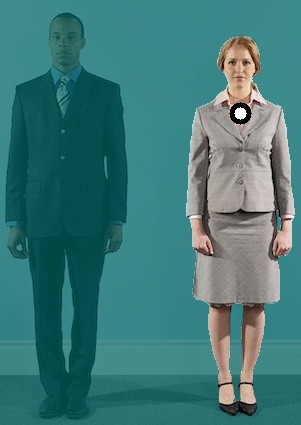

In [58]:
from IPython.display import Image
Image(filename=f'./segmented_images/{selected}.jpg')

In [59]:
cv2.imwrite(f'./segmented_images/{selected}.jpg', output_image)

True